# Outcome measured with uncertainty 

In real life, the outcome of interest is measured with imperfect test. Misclassification induced by such an imperfect diagnostic test will lead to biased estimates of the odds ratios and their variances. In that regard, it is important to consider sensitivity and specificity of the diagnostic. Prior information of these quantities lead to a bivariate analysis [1]. This notebook intends to use a bivariate Beta distribution built in [2]. I am going to use data from a Meta-analysis in which the telomerase
marker is used to diagnose bladder cancer taken from [3]. 

In [112]:
import pandas as pd 
import numpy as np
import pystan as ps

from scipy.special import gamma
from scipy.integrate import quad
from scipy.stats import gamma, loggamma
from scipy.optimize import root

import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
sns.set()

import pickle
from tqdm.notebook import tqdm

## Bivariate Beta

Let $U = (U_1, U_2, U_3, U_4) \sim
\operatorname{Dirichlet}(\boldsymbol{\alpha})$, where $\boldsymbol{\alpha} =
(\alpha_1, \alpha_2, \alpha_3, \alpha_4)$ with $\alpha_i > 0, i = 1,\dots,4$
and $U_4 = 1 - U_1 + U_2 + U_3$. The joint density of $U$ with respect to the
Lebesgue measure is given by
\begin{equation}
  f_U(u_1, u_2, u_3) = \frac{1}{B(\boldsymbol{\alpha})}u_1^{\alpha_1-1}u_2^{\alpha_2-1}u_3^{\alpha_3-1}(1-u_1-u_2-u_3)^{\alpha_4-1}, 
\end{equation}

when $u_i \in [0,1], i = 1,2,3$, $u_1 + u_2 + u_3 \le 1$, and $0$ otherwise.
The normalizing constant is, for $v \in \mathbb{R}^n$,

$$B(v) = \frac{\prod_{i=1}^n \Gamma(v_i)}{\Gamma\left(\sum_{i=1}^n v_i\right)}.$$ 

**Definition:** Let 
  \begin{equation}
    X = U_1 + U_2 \text{ and } Y = U_1 + U_3.
  \end{equation} 
    The distribution of $(X,Y)$ is *Bivariate Beta* with parameters
    $\boldsymbol{\alpha}$. 

I remember that the choice of all parameters to be less than one can lead to convergence problems, specially when $x=y$. 

We have that 

\begin{align*}
    X &\sim \operatorname{Beta}(\alpha_1 + \alpha_2, \alpha_3 + \alpha_4) \\
    Y &\sim \operatorname{Beta}(\alpha_1 + \alpha_3, \alpha_2 + \alpha_4) \\
    \operatorname{E}(X) &= \operatorname{E}(U_1 + U_2) = \frac{\alpha_1+\alpha_2}{\alpha_1+\alpha_2+\alpha_3+\alpha_4} \\
    \operatorname{E}(Y) &= \operatorname{E}(U_1 + U_3) = \frac{\alpha_1+\alpha_3}{\alpha_1+\alpha_2+\alpha_3+\alpha_4} \\
    \operatorname{Var}(X) &= \operatorname{Cov}(U_1+U_2, U_1+U_2) = \frac{1}{\tilde{\alpha}^2(\tilde{\alpha}+1)}(\alpha_1+\alpha_2)(\alpha_3 + \alpha_4) \\
    \operatorname{Var}(Y) &= \operatorname{Cov}(U_1+U_3, U_1+U_3) = \frac{1}{\tilde{\alpha}^2(\tilde{\alpha}+1)}(\alpha_1+\alpha_3)(\alpha_2 + \alpha_4)  \\ 
    \operatorname{Cor}(X,Y) &= \frac{\operatorname{Cov}(X,Y)}{\sqrt{\operatorname{Var}(X)\operatorname{Var}(Y)}} = \frac{\alpha_1\alpha_4 - \alpha_2\alpha_3}{\sqrt{(\alpha_1+\alpha_2)(\alpha_3+\alpha_4)(\alpha_1+\alpha_3)(\alpha_2+\alpha_4)}}
\end{align*}

In [108]:
constant_factor = lambda alpha: gamma(alpha).prod()/gamma(alpha.sum())

def f_u(u, x, y, alpha): 
    
    if (u == 0) or (u == x) or (u == y) or (u == x+y-1): 
        return 0
    
    fun  = u**(alpha[0]-1)
    fun *= (x-u)**(alpha[1]-1)
    fun *= (y-u)**(alpha[2]-1)
    fun *= (1-x-y+u)**(alpha[3]-1)
    
    return fun

def bivariate_beta_pdf(x, y, alpha): 
    
    if (x==0) or (y==0) or (x==1) or (y==1): 
        return 0
    
    c = constant_factor(alpha)
    
    lb = max(0,x+y-1)
    ub = min(x,y)
            
    return quad(f_u, lb, ub, args=(x,y,alpha))/c

def moments_calculus(alpha): 
    
    tilde_alpha = alpha[0]+alpha[1]+alpha[2]+alpha[3]
    
    E_X = (alpha[0]+alpha[1])/tilde_alpha
    E_Y = (alpha[0]+alpha[2])/tilde_alpha
    
    Var_X = (1/(tilde_alpha**2*(tilde_alpha+1)))*(alpha[0] + alpha[1])*(alpha[2] + alpha[3])
    Var_Y = (1/(tilde_alpha**2*(tilde_alpha+1)))*(alpha[0] + alpha[2])*(alpha[1] + alpha[3])
    
    den = np.log(alpha[0] + alpha[1]) + np.log(alpha[2]+alpha[3]) + np.log(alpha[0]+alpha[2]) + np.log(alpha[1]+alpha[3])
    den = np.exp(-0.5*den)
    Cor_XY = (alpha[0]*alpha[3] - alpha[1]*alpha[2])*den
    
    return (E_X, E_Y, Var_X, Var_Y, Cor_XY)

## Modelling with Bivariate Beta as prior. 

Let $Y_p$ denote the number of positives tests in $n_{pos}$ exposed to a disease individuals, and $Y_n$ denote the number of negative tests in $n_{neg}$ not exposed. The sensitivity $\gamma_s$ is the probability of positive test given the exposition, while the specificity $\gamma_e$ is the probability of a negative test given the non-exposition. Therefore, 

\begin{align*}
    Y_p &\sim Binomial(n_{pos}, \gamma_s) \\
    Y_n &\sim Binomial(n_{neg}, \gamma_e) \\
    \gamma_s &= U_1 + U_2 \\
    \gamma_e &= U_1 + U_3, 
\end{align*}

such that $(U_1, U_2, U_3, U_4) \sim Dirichlet(\alpha_1, \alpha_2, \alpha_3, \alpha_4)$. After we state that $\alpha_i \sim Gamma(a^i, b^i)$, where $a^i$ and $b^i$ are fixed.

In [15]:
compiled = True

In [14]:
if compiled: 
    sm = pickle.load(open('spec_sens_model.pkl', 'rb'))
else: 
    sm = ps.StanModel(file = 'spec_sens_model.stan')
    with open('spec_sens_model.pkl', 'wb') as f:
        pickle.dump(sm, f)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_26c3cca31d3e0943bc468d7c7b923298 NOW.


### Induced priors

In this model, we specify the priors on $\alpha$. However, the induced priors on the momments of $(X,Y)$ are complicated functions. For this, we generate samples from it. 

In [79]:
def prior_distributions(a, b, samples = 5000): 
    
    Z = [loggamma(c = a[i]).rvs(size = samples) for i in range(4)]
    alpha = [np.exp(Z[i])/b[i] for i in range(4)]
    
    X = np.random.beta(alpha[0] + alpha[1], alpha[2] + alpha[3])
    Y = np.random.beta(alpha[0] + alpha[2], alpha[1] + alpha[3])
    
    E_X, E_Y, Var_X, Var_Y, Cor_XY = moments_calculus(alpha)
    
    return (X, Y, E_X, E_Y, Var_X, Var_Y, Cor_XY)

#### Vague prior

We first use a vague prior $a_1 = a_2 = a_3 = a_4 = 1/100$ and $b_1 = b_2 = b_3 = b_4 = 1/100$. 

In [109]:
a = np.repeat(1/100, 4)
b = np.repeat(1/100, 4)

X, Y, E_X, E_Y, Var_X, Var_Y, Cor_XY = prior_distributions(a, b, samples = 10000)

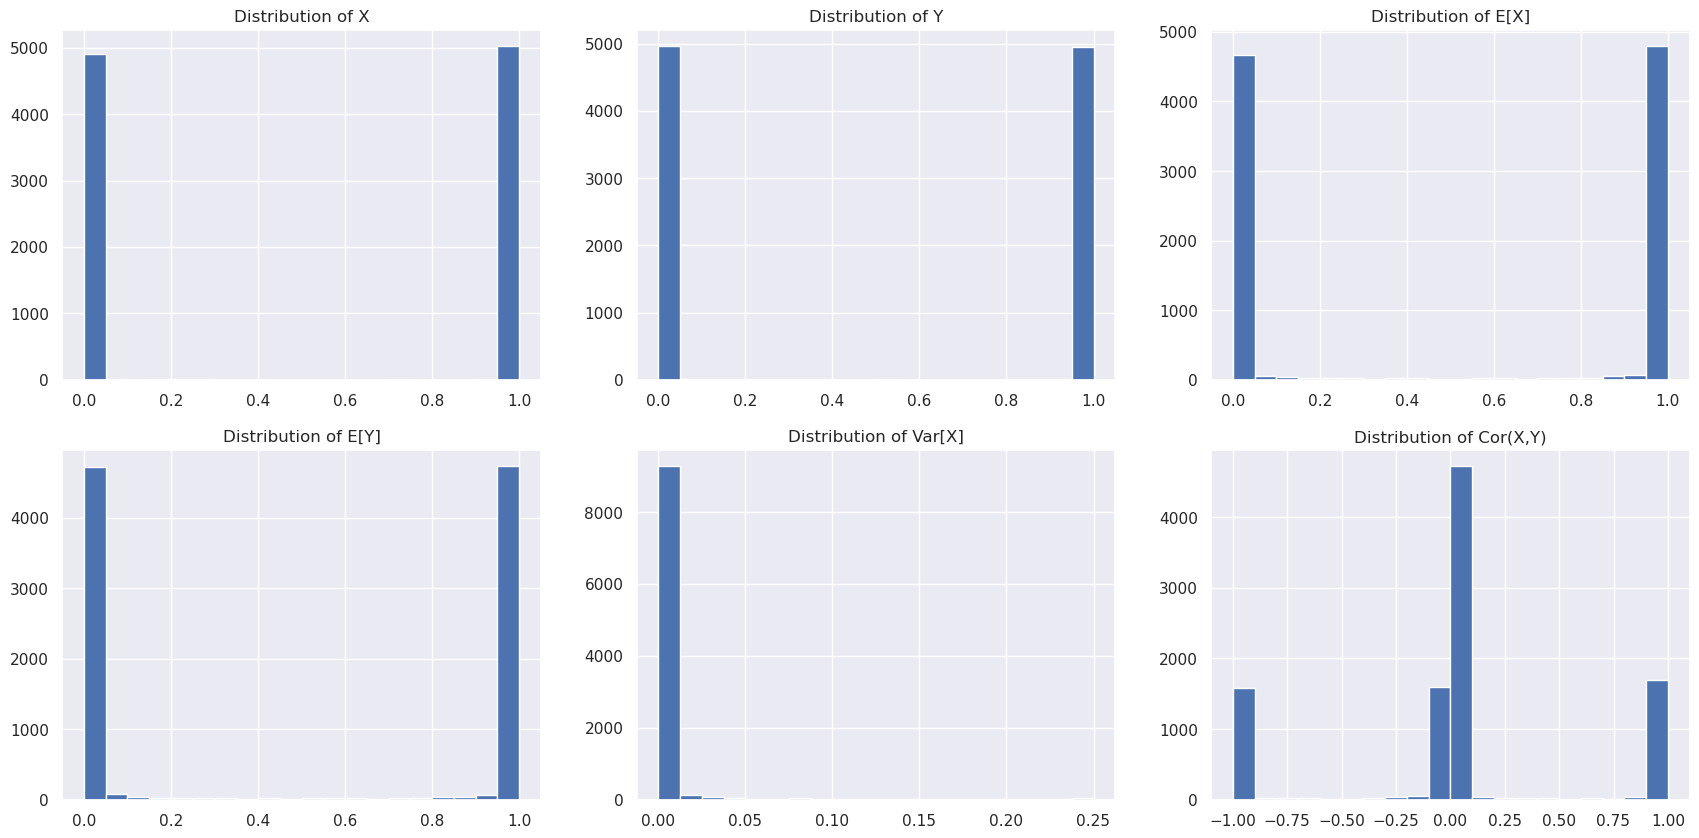

In [110]:
fig, ax = plt.subplots(2,3, figsize = (21,10))

ax[0,0].hist(X, bins = 20)
ax[0,1].hist(Y, bins = 20)
ax[0,2].hist(E_X, bins = 20)
ax[1,0].hist(E_Y, bins = 20)
ax[1,1].hist(Var_X, bins = 20)
ax[1,2].hist(Cor_XY, bins = 20)

ax[0,0].set_title('Distribution of X')
ax[0,1].set_title('Distribution of Y')
ax[0,2].set_title('Distribution of E[X]')
ax[1,0].set_title('Distribution of E[Y]')
ax[1,1].set_title('Distribution of Var[X]')
ax[1,2].set_title('Distribution of Cor(X,Y)')

plt.show()

More informative prior:$a_1 = a_2 = a_3 = a_4 = 1$ and $b_1 = b_2 = b_3 = b_4 = 1$.

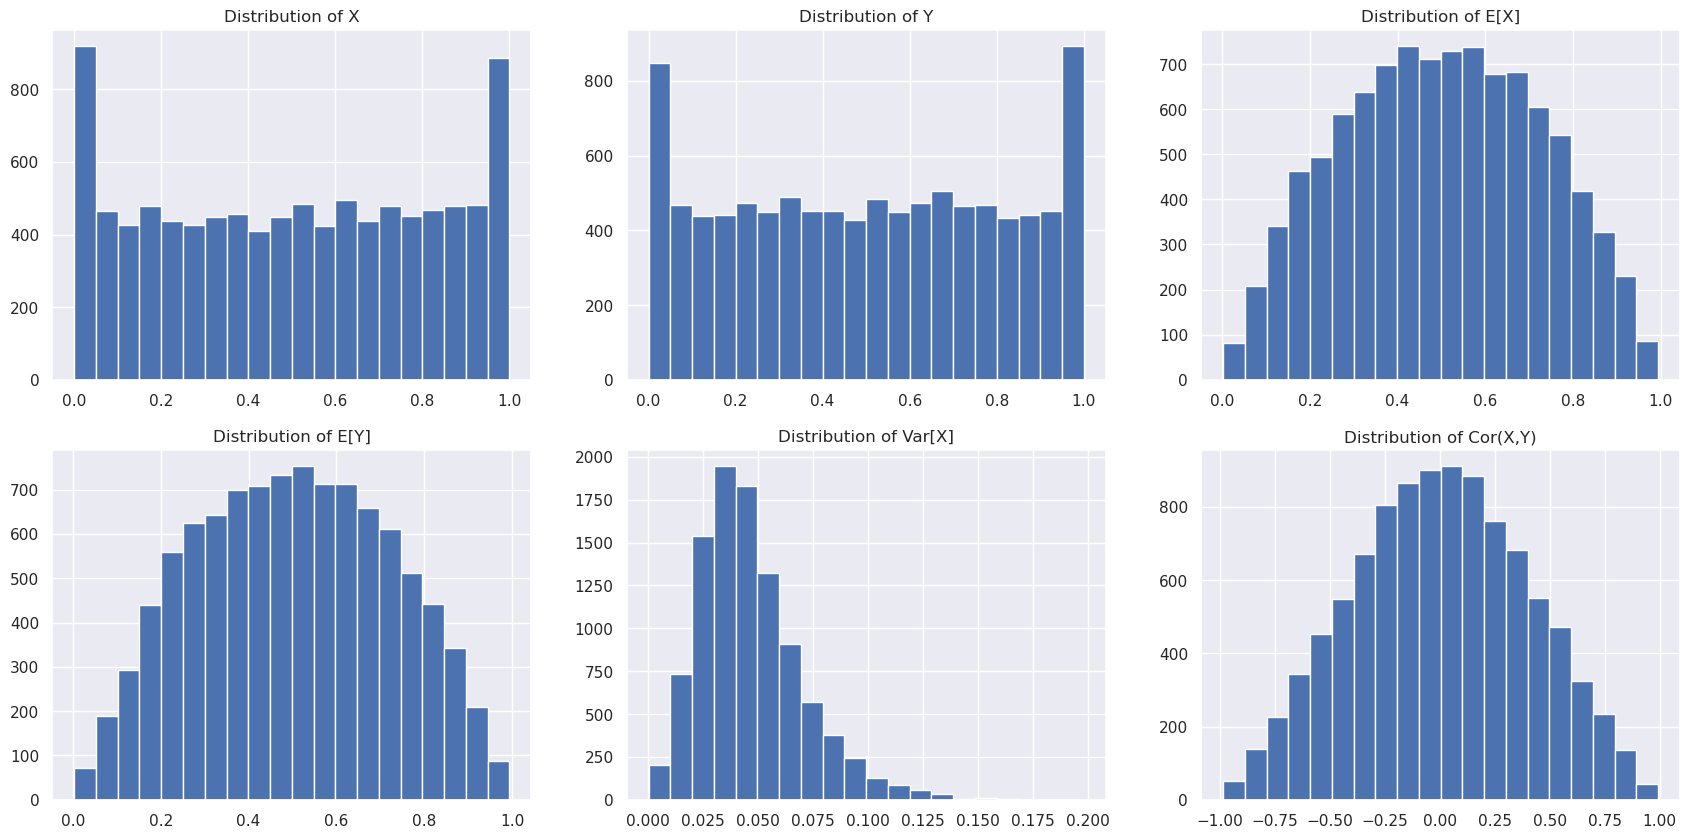

In [111]:
a = np.repeat(1, 4)
b = np.repeat(1, 4)

X, Y, E_X, E_Y, Var_X, Var_Y, Cor_XY = prior_distributions(a, b, samples = 10000)

fig, ax = plt.subplots(2,3, figsize = (21,10))

ax[0,0].hist(X, bins = 20)
ax[0,1].hist(Y, bins = 20)
ax[0,2].hist(E_X, bins = 20)
ax[1,0].hist(E_Y, bins = 20)
ax[1,1].hist(Var_X, bins = 20)
ax[1,2].hist(Cor_XY, bins = 20)

ax[0,0].set_title('Distribution of X')
ax[0,1].set_title('Distribution of Y')
ax[0,2].set_title('Distribution of E[X]')
ax[1,0].set_title('Distribution of E[Y]')
ax[1,1].set_title('Distribution of Var[X]')
ax[1,2].set_title('Distribution of Cor(X,Y)')

plt.show()

After compiling the model, we generate fake data to understand what happens. We will compare independent generated sensitivity and specificity from dependent. For the priors on $\alpha$, weak informative gamma distributions are placed. First, let's see the induced prior on the momments. 

TODO

## Impact on the moments 

The Bivariate Beta has four parameters. However, each marginal beta distribution has two paramters. When they are fixed, the correlation between the marginals will have a fixed form. We compare how these quantities relate. Suppose we know $E[X], E[Y], Var[X],$ and $Var[Y]$.

In [126]:
a = np.array([1,-1])
a<0

array([False,  True])

In [141]:
def find_alphas(e_x, e_y, var_x, var_y): 
    
    fun = lambda alpha: np.array(moments_calculus(alpha)[:-1]) - np.array([e_x, e_y, var_x, var_y]) + sum(alpha<=0)
                                                                                                        
    sol = root(fun = fun, x0 = 10*np.ones(4))
    
    return sol

In [142]:
sol = find_alphas(0.9, 0.85, 0.01, 0.01)
sol.x

<ipython-input-108-78c87641655d>:37: RuntimeWarning: invalid value encountered in log
  den = np.log(alpha[0] + alpha[1]) + np.log(alpha[2]+alpha[3]) + np.log(alpha[0]+alpha[2]) + np.log(alpha[1]+alpha[3])


array([150.29517955,  27.60942701,  17.60923977,   2.09172029])

In [143]:
moments_calculus(sol.x)

(0.900301593738941,
 0.8496947843605527,
 0.0004519442006442571,
 0.0006430512495890484,
 -0.041094358356299425)

We have data of True Positives (TP), False Negatives (FN), True Negatives (TN), and False Positives (FP). Note that the empirical estimator of sensitivity $\gamma_s$ is 

$$
\hat{\gamma}_s = \frac{TP}{TP + FN}
$$

and of especificity $\gamma_e$ is 

$$
\hat{\gamma}_e = \frac{TN}{TN + FP}.
$$

The initial ideia is to use the estimators from different studies and to use this information in the bivariate beta ditribution. 

In [8]:
studies = pd.read_csv('../../data/telomerase_meta_analysis.csv')
studies

,Study,TP,FN,TN,FP
0,Ito et al. (1998),25,8,25,1
1,Rahat et al. (1999),17,4,11,3
2,Kavaler et al. (1998),88,16,31,16
3,Yoshida et al. (1997),16,10,80,3
4,Ramakumar et al. (1999),40,17,137,1
5,Landman et al. (1998),38,9,24,6
6,Kinoshita et al. (1997),23,19,12,0
7,Gelmini et al. (2000),27,6,18,2
8,Cheng et al. (2000),14,3,29,3
9,Cassel et al. (2001),37,7,7,22


In [12]:
studies['sens'] = studies['TP']/(studies['TP'] + studies['FN'])
studies['spec'] = studies['TN']/(studies['TN'] + studies['FP'])

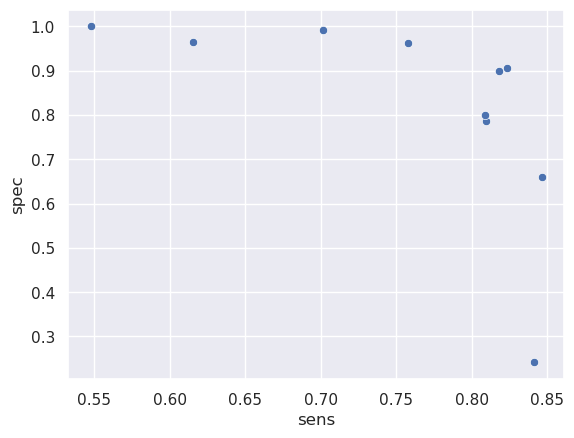

In [18]:
sns.scatterplot(x = 'sens', y = 'spec', data = studies)
plt.show()

## References 

[1] Guo, J., Riebler, A., and Rue, H. (2017) Bayesian bivariate meta-analysis of diagnostic test studies with interpretable priors. Statist. Med., 36: 3039– 3058. doi: 10.1002/sim.7313.

[2] Olkin, Ingram & Trikalinos, Thomas. (2014). Constructions for a bivariate beta distribution. Statistics & Probability Letters. 96. 10.1016/j.spl.2014.09.013. 

[3] Glas AS, Roos D, Deutekom M, Zwinderman AH, Bossuyt PMM, Kurth KH. Tumor markers in the diagnosis of primary bladder cancer. A systematic review. The Journal of Urology 2003; 169(6):1975–1982.